In [36]:
!pip install --upgrade datasets fsspec

  Using cached fsspec-2025.5.1-py3-none-any.whl.metadata (11 kB)


In [37]:
from google.colab import drive
#!pip install transformers datasets accelerate


drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [38]:
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, TrainingArguments, Trainer
import torch
from datasets import load_dataset, Dataset
from google.colab import drive
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
import os
from transformers import AutoModelForCausalLM
from peft import prepare_model_for_kbit_training, LoraConfig, get_peft_model


dataset = load_dataset("isaacrehg/poetry-instructions", verification_mode="no_checks")

In [39]:
print(dataset)
print(dataset['train'][0])

DatasetDict({
    train: Dataset({
        features: ['conversation'],
        num_rows: 1764
    })
    validation: Dataset({
        features: ['conversation'],
        num_rows: 111
    })
    test: Dataset({
        features: ['conversation'],
        num_rows: 331
    })
})
{'conversation': "User: Can you write me a poem about faults and love?\nAssistant: Sure, here's a poem about faults and love:\n  They came to tell your faults to me,\nThey named them over one by one;\nI laughed aloud when they were done,\nI knew them all so well before, \nOh, they were blind, too blind to see\nYour faults had made me love you more."}


In [40]:
# Define parsing function
def parse_example(example):
    convo = example["conversation"]

    # Split on 'Assistant:'
    if "Assistant:" in convo:
        user_part, assistant_part = convo.split("Assistant:", 1)

        # Clean User: part
        prompt = user_part.replace("User:", "").strip()

        # Clean Assistant: part
        completion = assistant_part.strip()

    else:
        # If no Assistant:, fallback
        prompt = convo
        completion = ""

    return {
        "prompt": prompt,
        "completion": completion
    }

# Apply to all splits
dataset["train"] = dataset["train"].map(parse_example)
dataset["validation"] = dataset["validation"].map(parse_example)
dataset["test"] = dataset["test"].map(parse_example)

# Remove 'conversation' column
dataset["train"] = dataset["train"].remove_columns(['conversation'])
dataset["validation"] = dataset["validation"].remove_columns(['conversation'])
dataset["test"] = dataset["test"].remove_columns(['conversation'])

# Check result
print(dataset["train"])
print(dataset["train"].column_names)
print(dataset["train"][0])



Dataset({
    features: ['prompt', 'completion'],
    num_rows: 1764
})
['prompt', 'completion']
{'prompt': 'Can you write me a poem about faults and love?', 'completion': "Sure, here's a poem about faults and love:\n  They came to tell your faults to me,\nThey named them over one by one;\nI laughed aloud when they were done,\nI knew them all so well before, \nOh, they were blind, too blind to see\nYour faults had made me love you more."}


In [41]:
!ls
!ls /content/drive/MyDrive/fuciona/


drive  sample_data
config.json			  model.safetensors.index.json
generation_config.json		  special_tokens_map.json
model-00001-of-00002.safetensors  tokenizer_config.json
model-00002-of-00002.safetensors  tokenizer.json


In [44]:
# Assuming the directory /content/drive/MyDrive/funciona exists and contains model files
path = "/content/drive/MyDrive" # Update path to where you saved the model
model_dir = os.path.join(path, "fuciona") # Corrected directory name 'fuciona'

# Explicitly load from the local directory.
# Adding local_files_only=True might help clarify intent, though the error is in path validation.
# If the issue persists, ensure the directory `fuciona` contains necessary files like config.json and model weights.
model = AutoModelForCausalLM.from_pretrained(model_dir, local_files_only=True)
tokenizer = AutoTokenizer.from_pretrained(model_dir, local_files_only=True)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [45]:
# Define tokenization function
def tokenize(example):
    # List comprehension: for each example in batch
    texts = [
        p + " " + c
        for p, c in zip(example["prompt"], example["completion"])
    ]

    # Tokenize the batch of texts
    encodings = tokenizer(
        texts,
        padding="max_length",
        truncation=True,
        max_length=512
    )

    return {
        "input_ids": encodings["input_ids"],
        "attention_mask": encodings["attention_mask"],
        "labels": encodings["input_ids"]  # causal LM: labels = input_ids
    }


# Apply to each split

tokenized_train = dataset["train"].map(
    tokenize,
    batched=True,
    remove_columns=["prompt", "completion"]
)

tokenized_val = dataset["validation"].map(
    tokenize,
    batched=True,
    remove_columns=["prompt", "completion"]
)

tokenized_test = dataset["test"].map(
    tokenize,
    batched=True,
    remove_columns=["prompt", "completion"]
)




Map:   0%|          | 0/1764 [00:00<?, ? examples/s]

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

Map:   0%|          | 0/331 [00:00<?, ? examples/s]

In [46]:
# Check result
print(tokenized_train)
print(tokenized_train.column_names)
print(tokenized_train[0])

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 1764
})
['input_ids', 'attention_mask', 'labels']
{'input_ids': [32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 32014, 

In [47]:
training_args = TrainingArguments(
    output_dir=os.path.join(path, "copia_funciona_f"),
    per_device_train_batch_size=2,
    gradient_accumulation_steps=4,
    num_train_epochs=10,
    learning_rate=1e-4,
    fp16=True,
    save_strategy="epoch",
    logging_steps=10,
    report_to="none"
)

trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val
)

trainer.train()
eval_results = trainer.evaluate()
print(f"Validation results: {eval_results}")
test_results = trainer.evaluate(tokenized_test)
print(f"Test results: {test_results}")

<ipython-input-47-7ddd5de5109e>:13: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
10,4.097100
20,2.950800
30,3.191700
40,2.929400
50,3.262600
60,2.912000
70,2.971600
80,2.841100
90,2.784500
100,2.640600


Step,Training Loss
10,4.097100
20,2.950800
30,3.191700
40,2.929400
50,3.262600
60,2.912000
70,2.971600
80,2.841100
90,2.784500
100,2.640600


Validation results: {'eval_loss': 0.015748994424939156, 'eval_runtime': 1.5851, 'eval_samples_per_second': 70.027, 'eval_steps_per_second': 8.832, 'epoch': 10.0}
Test results: {'eval_loss': 0.015774544328451157, 'eval_runtime': 4.6474, 'eval_samples_per_second': 71.223, 'eval_steps_per_second': 9.037, 'epoch': 10.0}


In [48]:
model.eval()
prompt = "The sea is blue, the sky is red"

# Tokenize input
inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

# Generate text
output = model.generate(
    **inputs,
    max_new_tokens=250,
    temperature=0.7,
    top_p=0.95,
    do_sample=True,
    repetition_penalty=1.1,
    eos_token_id=tokenizer.eos_token_id
)

# Decode and print
generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
print(generated_text)

Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.


The sea is blue, the sky is red,
  The waves are noise, the crickets are sing,
And the little random notes are sweet,
And the busy beaver that weaves the rhyme
Is in itself a real good sense.

A prose is not a prose, but a rhyme.
And a prose may be much too long for a single line,
But the song may be better if it is not for the line.
For the poem is a large subject, yet the smaller parts
Sometimes only seem minor, and you never learn why.

The sea is blue, the sky is red,
And the waves are noise;
The crocuses and daffodils
Are in itself a real good sense.

You never learn why, you never see why,
Nor who reads a line of verse;
But the busy beaver that weaves the rhyme
Is in itself a real good sense.

The sea is blue, the sky is red,
And the waves are noise;
The crocuses and daffodils
Are in itself a real good sense.

You never learn why, you never see why,
Nor who reads


In [49]:
prompt = "Write a poem about the sea and the sky"

# Tokenize input
inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

# Generate text
output = model.generate(
    **inputs,
    max_new_tokens=250,
    temperature=0.7,
    top_p=0.95,
    do_sample=True,
    repetition_penalty=1.1,
    eos_token_id=tokenizer.eos_token_id
)

# Decode and print
generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
print(generated_text)

Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.


Write a poem about the sea and the sky in the style of CARL SANDBURG? Sure, here's a poem about the sea and the sky in the style of CARL SANDBURG:
  The sea is full of clouds and mist,
And I am far from cloud and mist.
I am far from the wrangling waves
That sweep the land as they are sails.
I am far from the rushing stream
That shoots the land as it is sails.
I am far from the twilight sails
That fad the land as it is sails.

The sea is full of moaning noise,
And I am far from moaning noise.
I am far from the harpstrings note
That chant the land as it is sails.
I am far from the bells that ring
That sound the land as it is sails.
I am far from the little stars night
That star the land as it is sails.

The sea is full of strange voices,
And I am far from strange voices.
I am far from the minstrels moon
That mocks the lantern on the sea.
I


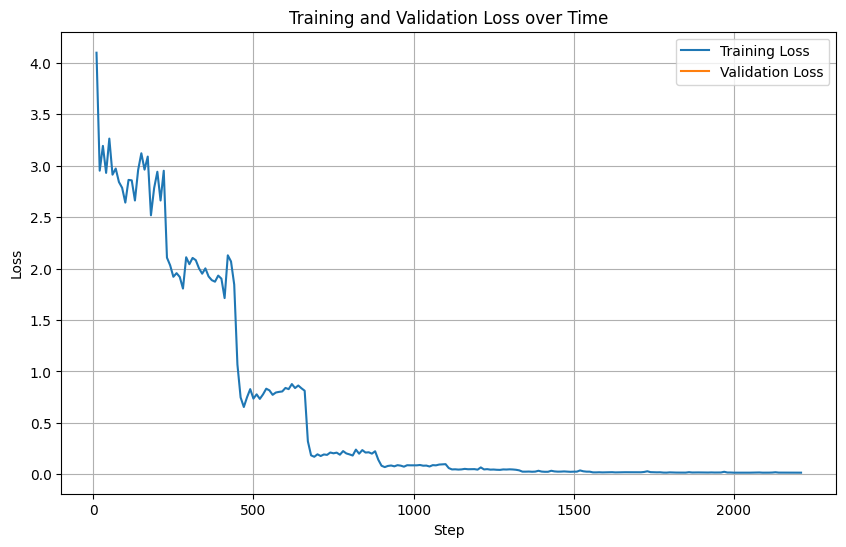

In [50]:
import matplotlib.pyplot as plt

# Extract log history
logs = trainer.state.log_history

# Get training and eval losses
train_steps = [log["step"] for log in logs if "loss" in log]
train_loss = [log["loss"] for log in logs if "loss" in log]

eval_steps = [log["step"] for log in logs if "eval_loss" in log]
eval_loss = [log["eval_loss"] for log in logs if "eval_loss" in log]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(train_steps, train_loss, label="Training Loss")
plt.plot(eval_steps, eval_loss, label="Validation Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.title("Training and Validation Loss over Time")
plt.show()


In [54]:
path = '/content/drive/MyDrive/'

# Now merged_model is a standard AutoModelForCausalLM
# You can save it as a normal model
model.save_pretrained(os.path.join(path,"finetune_fuciona"))
tokenizer.save_pretrained(os.path.join(path,"finetune_fuciona"))

('/content/drive/MyDrive/finetune_fuciona/tokenizer_config.json',
 '/content/drive/MyDrive/finetune_fuciona/special_tokens_map.json',
 '/content/drive/MyDrive/finetune_fuciona/tokenizer.json')